## `Abnormal Return, AbR` - wykrywanie zdarzeń

---

Aby wyznaczyć daty zdarzeń (ang. Event Date Detection, EDD) w tym artykule, można zastosować metodę analizy abnormal returns — czyli "nienormalnych zwrotów" ceny akcji — która pozwala identyfikować daty potencjalnych wydarzeń mających wpływ na rynek. Kroki są następujące:

1. Obliczenie rozkładu procentowego zwrotu ceny dla danej daty:

Obliczamy, na ile zwrot ceny w danym dniu jest nietypowy w porównaniu z wcześniejszymi wartościami. Aby to zrobić, stosujemy procentowe zwroty:
$$
pctl = (R_0, ..., R_n) = \frac{\sum_{i=1}^n step(sign(R_0)*(R_0 - R_i))}{n}
$$
Gdzie:
- $R_0$ to zwrot ceny w dniu, dla którego liczymy wartość, a $R_1, ..., R_n$ zwroty w n wcześniejszych dniach,
- Funkcja `step(x)` wynosi $1$, gdy $x>0$ , i $0$ w przeciwnym przypadku.

2. Wyznaczenie miary anormalności
Aby ułatwić identyfikację daty zdarzenia, warto wprowadzić miarę nienormalności zwrotu (*Abnormal Return, AbR*), która bierze pod uwagę zarówno zmienność długookresową, jak i krótkookresową. Formuła nienormalności jest następująca:
$$
    AbR(R_0​,R_1​,…,R_L​)=pctl(R_0​,R_1​,…,R_L​)×pctl(∣R_0​∣,∣R_1​∣,…,∣R_L​∣)×pctl(R_0​,R_1​,…,R_S​)×pctl(∣R_0​∣,∣R_1​∣,…,∣R_S​∣)
$$
Gdzie:
- $L$ to liczba dni dla długiego okresu,
- $S$ to liczba dni dla krótkiego okresu.

3. Wyznaczenie daty zdarzenia

Po obliczeniu wartości AbR dla danego dnia, porównuje się ją z ustalonym progiem, np. $0,94$ (zgodnie z artykułem). Jeśli *AbR* przekroczy próg, dzień uznaje się za datę zdarzenia.

Źródło: Event Detection in Financial Markets, *Mohammad Shirdel, Michele Segata, Giuseppe Di Fatta, Antonio Liotta*, Year: 2022 | Conference Paper | Publisher: IEEE




---

Implementacja `./scripts/eventDateDetect.py`  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scripts import EDD
from scripts import StockPriceDatabase
pd.options.mode.chained_assignment = None 

In [8]:
# Example of AbR
TICKER = "CCC"

# Download example market price
spd = StockPriceDatabase()
market_historical = spd.get_stock_price(TICKER)

# Get selected data
market_data = market_historical[["Close"]]
market_data["Returns"] = market_data["Close"].pct_change()
market_data = market_data.dropna()

# Calculate AbR
market_data["AbR"] = EDD.abr(market_data["Returns"].to_numpy())
market_data

,Close,Returns,AbR
Date,,,
2004-12-03,7.8682,-0.015971,0.000000
2004-12-06,7.7151,-0.019458,0.000044
2004-12-07,7.5535,-0.020946,0.000711
2004-12-08,7.5111,-0.005613,0.000000
2004-12-09,7.5535,0.005645,0.000711
...,...,...,...
2024-09-23,155.6000,0.012362,0.069333
2024-09-24,152.1000,-0.022494,0.166400
2024-09-25,178.0000,0.170283,1.000000


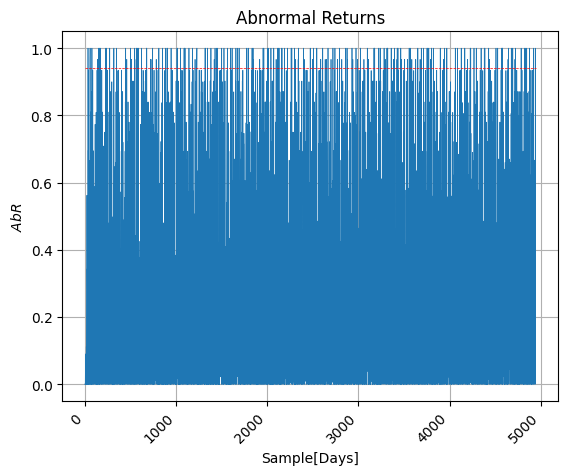

In [13]:
plt.plot(market_data["AbR"].to_numpy(), linewidth = 0.5)
plt.hlines(0.94, 0, market_data["AbR"].size, "r", linestyles="dashed", linewidth = 0.5)
plt.xticks(rotation=45, ha='right')
plt.title("Abnormal Returns")
plt.ylabel(r"$AbR$")
plt.xlabel("Sample[Days]")
plt.grid()
plt.show()


### Density WIG ODZIEZ

In [129]:
from scripts import StockDatabase, UtilsStockPrice

sdb = StockDatabase()

# Read all tickers for WIG_ODZIEZ sector
tickers = pd.read_csv("../database/designData/WIGs.csv")["WIG_ODZIEZ"].dropna()

report = pd.read_csv("../database/reportData/Quarterly_Diff.csv", index_col=[0])
report = report.rename(columns={"Date": "D_DATE"})
report["D_DATE"] = report["D_DATE"].astype("datetime64[s]")
report = report[np.any([report["Ticker"] == t for t in tickers], axis=0)]
report = report.iloc[:, 0:2]

days_outside = 0 
days_inside = 0
abr_outside = 0
abr_inside = 0

analysis_space = np.arange(0,30)
density_outside = []
density_inside = []

for space in analysis_space:
    for ticker in tickers:
        # Get selected data
        market_historical = spd.get_stock_price(ticker)
        market_data = market_historical[["Close"]]
        market_data["Returns"] = market_data["Close"].pct_change()
        market_data = market_data.dropna()

        # Calculate AbR
        market_data["AbR"] = EDD.abr(market_data["Returns"].to_numpy())
        market_data.index = market_data.index.astype("datetime64[s]")
        market_data = market_data["AbR"]

        mask = np.zeros(market_data.shape)

        for _, row in report[report["Ticker"]==ticker].iterrows():
            idx = np.argmax(market_data.index == row["D_DATE"])
            if idx == 0:
                continue
            mask[idx-space:idx+space+1] = True

        abr_inside = abr_inside + np.sum(market_data[mask.astype('bool')] > 0.94)
        days_inside = days_inside + np.sum(mask.astype('bool'))
        abr_outside = abr_outside + np.sum(market_data[~mask.astype('bool')] > 0.94)
        days_outside = days_outside + np.sum(~mask.astype('bool'))
    density_outside.append(abr_outside / days_outside)
    density_inside.append(abr_inside / days_inside)

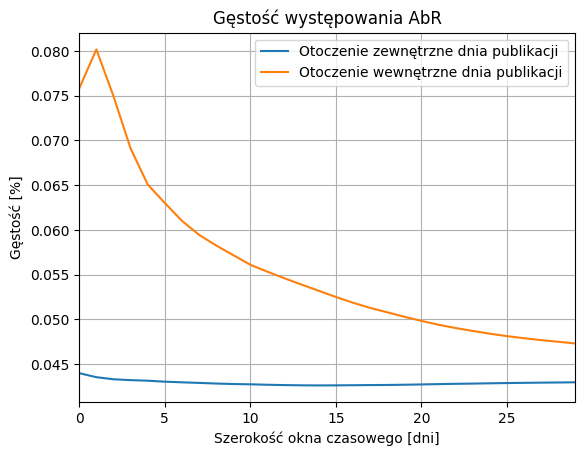

In [138]:
plt.plot(analysis_space, density_outside, label="Otoczenie zewnętrzne dnia publikacji")
plt.plot(analysis_space, density_inside, label="Otoczenie wewnętrzne dnia publikacji")
plt.title("Gęstość występowania AbR")
plt.xlabel("Szerokość okna czasowego [dni]")
plt.ylabel("Gęstość [%]")
plt.xlim([0,29])
plt.legend()
plt.grid()
plt.show()

## Metoda średniego zwrotu (Mean Return Model)
---

To najprostsza metoda, polegająca na obliczeniu średniego dziennego zwrotu z wybranego okresu przed incydentem.

Krok 1: Zbieranie danych

Zbierz historyczne dane cen akcji za okres np. 30-60 dni przed incydentem.

Krok 2: Obliczenie dziennych zwrotów

Dzienny zwrot ($R_t$) dla każdego dnia obliczysz za pomocą wzoru:
$$
R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$
Gdzie:

$R_t$ to dzienny zwrot w dniu $t$,

$P_t$ to cena zamknięcia akcji w dniu $t$,

$P_{t-1}$ to cena zamknięcia akcji w dniu poprzedzającym $t$.


Krok 3: Obliczenie średniego zwrotu

Średni zwrot z okresu przed incydentem obliczasz jako:
$$
\overline{R} = \frac{1}{N} \sum_{t=1}^{N} R_t
$$
Gdzie:

$N$ to liczba dni w okresie przed incydentem,

$R_t$ to zwroty z każdego dnia.


Krok 4: Prognozowanie zwrotów normalnych
Załóżmy, że normalny dzienny zwrot w okresie po incydencie będzie równy temu średniemu zwrotowi. Zwrot normalny w dniu $t$ po incydencie wynosi:
$$
\text{Zwrot normalny}_t = \overline{R}_t
$$

In [3]:
N_WINDOW_SIZE = 15
# Example of AbR
TICKER = "CCC"

# Download example market price
spd = StockPriceDatabase()
market_historical = spd.get_stock_price(TICKER)

# Get selected data
market_data = market_historical[["Close"]]
market_data["Returns"] = market_data["Close"].pct_change()
market_data["MEAN(PrevReturns)"] = np.roll(market_data["Returns"].rolling(N_WINDOW_SIZE).mean(), -1)
market_data = market_data.dropna()

# Calculate EPs
market_data["EPS"] = market_data["Returns"] - market_data["MEAN(PrevReturns)"] 
market_data

,Close,Returns,MEAN(PrevReturns),EPS
Date,,,,
2004-12-22,7.4686,-0.005658,-0.004041,-0.001617
2004-12-23,7.5111,0.005690,-0.002298,0.007988
2004-12-24,7.5876,0.010185,-0.000254,0.010439
2004-12-27,7.6725,0.011189,0.000774,0.010415
2004-12-28,7.6302,-0.005513,0.001149,-0.006662
...,...,...,...,...
2024-09-20,153.7000,-0.029059,-0.001139,-0.027920
2024-09-23,155.6000,0.012362,-0.002177,0.014538
2024-09-24,152.1000,-0.022494,0.009978,-0.032472


### Results


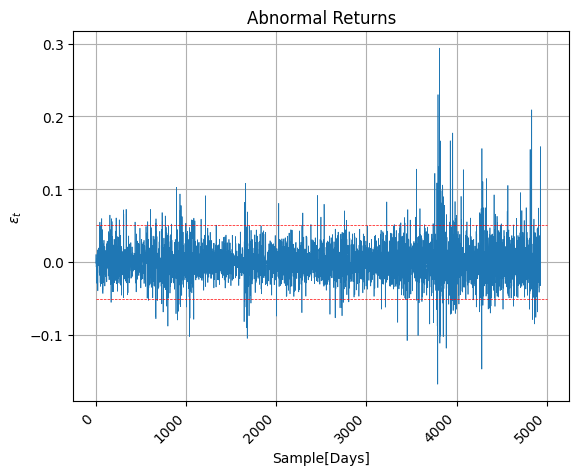

In [4]:
plt.plot(market_data["EPS"].to_numpy(), linewidth = 0.5)
plt.hlines(market_data["EPS"].mean() + 2 * market_data["EPS"].std(), 0, 5000, "r", linestyles="dashed", linewidth = 0.5)
plt.hlines(market_data["EPS"].mean() - 2 * market_data["EPS"].std(), 0, 5000, "r", linestyles="dashed", linewidth = 0.5)
plt.xticks(rotation=45, ha='right')
plt.title("Abnormal Returns")
plt.ylabel(r"$\epsilon_t$")
plt.xlabel("Sample[Days]")
plt.grid()
plt.show()

## Model rynkowy (Market Model)
---

Ta metoda jest bardziej zaawansowana, ponieważ bierze pod uwagę ruchy całego rynku (np. indeks giełdowy).

Krok 1: Wybór indeksu rynkowego

Wybierz odpowiedni indeks rynkowy, np. WIG20, S\&P 500 itp., który będzie służył jako benchmark.

Krok 2: Obliczenie dziennych zwrotów dla akcji i indeksu

Oblicz dzienne zwroty zarówno dla akcji, jak i dla wybranego indeksu w okresie przed incydentem (tak jak w kroku 2 metody średniego zwrotu).

Krok 3: Regresja liniowa

Przeprowadź regresję liniową, gdzie:
$$
R_t = \alpha + \beta R_{M,t} + \epsilon_t
$$
Gdzie:

$R_t$ to dzienny zwrot akcji w dniu $t$,

$R_{M,t}$ to dzienny zwrot indeksu rynkowego w dniu $t$,

$\alpha$ to stała (intercept),

$\beta$ to współczynnik nachylenia (slope),

$\epsilon_t$ to składnik losowy (residual).


Krok 4: Prognozowanie zwrotów normalnych
Dla każdego dnia po incydencie prognozowany zwrot normalny obliczasz za pomocą wzoru:
$$
\text{Zwrot normalny}_t = \alpha + \beta R_{M,t} 
$$


In [5]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

N_WINDOW_SIZE = 15
# Example of AbR
TICKER = "CCC"
WIG_TICKER = "WIG_ODZIEZ"

# Download example market price
spd = StockPriceDatabase()
company_historical = spd.get_stock_price(TICKER)
index_historical = spd.get_stock_price(WIG_TICKER)
market_historical = company_historical.join(index_historical, how="inner", 
                                            lsuffix="_CMP", rsuffix="_IDX")[["Close_CMP", "Close_IDX"]]

# Calculate returns 
market_historical["Returns_CMP"] = market_historical["Close_CMP"].pct_change()
market_historical["Returns_IDX"] = market_historical["Close_IDX"].pct_change()
market_historical = market_historical.dropna()

# Linear regression 
y = market_historical["Returns_CMP"]
x = market_historical["Returns_IDX"]
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
model.summary()

alpha = model.params["const"] 
beta  = model.params["Returns_IDX"] 

# Calculate error  
market_historical["EPS"] = market_historical["Returns_CMP"] - (beta * market_historical["Returns_IDX"] + alpha)
market_historical

,Close_CMP,Close_IDX,Returns_CMP,Returns_IDX,EPS
Date,,,,,
2017-01-03,212.29,5167.92,0.029335,-0.001306,0.030527
2017-01-04,206.19,5122.17,-0.028734,-0.008853,-0.021304
2017-01-05,204.71,5045.15,-0.007178,-0.015037,0.005365
2017-01-09,207.70,5109.78,0.014606,0.012810,0.004128
2017-01-10,212.19,5189.12,0.021618,0.015527,0.008893
...,...,...,...,...,...
2024-09-23,155.60,9879.81,0.012362,0.017291,-0.001821
2024-09-24,152.10,9886.30,-0.022494,0.000657,-0.022925
2024-09-25,178.00,10571.93,0.170283,0.069352,0.113061


## Model sieci LSTM
---

In [5]:
import numpy as np
import pandas as pd
from scripts import StockPriceDatabase
pd.options.mode.chained_assignment = None 

In [12]:
# Download example market price
spd = StockPriceDatabase()
TICKER = "CCC"
market_historical = spd.get_stock_price(TICKER)

# Get stock prices
prices = market_data["Close"].to_numpy().reshape(-1,1)

In [101]:
# Read all data - without wig_odziez
tickers = pd.read_csv("../database/designData/WIGs.csv").drop(columns=["WIG_POLAND", "WIG_ODZIEZ"]).fillna("NaN").to_numpy().flatten()
tickers = tickers[tickers != "NaN"]

is_first = True

for ticker in tickers:
    market_historical = spd.get_stock_price(ticker)
    prices = market_data["Close"].to_numpy().reshape(-1,1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    prices_scaled = scaler.fit_transform(prices)

    train_size = int(len(prices_scaled) * 0.7)
    np.random.shuffle(prices_scaled)
    train_data, test_data = prices_scaled[:train_size], prices_scaled[train_size:]
    x_train, y_train = windowing_signal(train_data)
    x_test, y_test = windowing_signal(train_data)

    if is_first:
        X_train = np.copy(x_train) 
        Y_train = np.copy(y_train) 
        X_test = np.copy(x_test) 
        Y_test = np.copy(y_test) 
        is_first = False
    else:
        X_train = np.concat([X_train, x_train])
        Y_train = np.concat([Y_train, y_train])
        X_test = np.concat([X_test, x_test])
        Y_test = np.concat([Y_test, y_test])


In [57]:
## Data preprocessing
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)
# Method for windowing signals
def windowing_signal(signal, n=60):
    x = []
    y = []
    for i in range(n, len(signal)):
        x.append(signal[i-n : i, 0])
        y.append(signal[i, 0])
    x = np.array(x)
    y = np.array(y)

    return x.reshape(x.shape[0], x.shape[1], 1), y.reshape(y.shape[0], 1)

# Split the data into training and testing sets
train_size = int(len(prices_scaled) * 0.7)
np.random.shuffle(prices_scaled)
train_data, test_data = prices_scaled[:train_size], prices_scaled[train_size:]
x_train, y_train = windowing_signal(train_data)
x_test, y_test = windowing_signal(train_data)

In [105]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.saving import load_model

# Build the LSTM model
model = Sequential()
model.add(Input(shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')

In [108]:
# Train the model
history = model.fit(X_train, Y_train, epochs=100, batch_size=512)

Epoch 1/100
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 305s 296ms/step - loss: 0.0521
Epoch 2/100
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 305s 296ms/step - loss: 0.0519
Epoch 3/100
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 296s 288ms/step - loss: 0.0519
Epoch 4/100
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 285s 277ms/step - loss: 0.0516
Epoch 5/100
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 285s 277ms/step - loss: 0.0519
Epoch 6/100
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 285s 277ms/step - loss: 0.0519
Epoch 7/100
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 285s 276ms/step - loss: 0.0515
Epoch 8/100
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 285s 276ms/step - loss: 0.0517
Epoch 9/100
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 285s 277ms/step - loss: 0.0516
Epoch 10/100
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 285s 277ms/step - loss: 0.0516
Epoch 11/100
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 285s 277ms/step - loss: 0.0518
Epoch 12/100
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 285s 277ms/step - loss: 0.0516
Epoch 13/100
1030/1030 ━━━━━━━━━━━━━━━━━━━━ 285s 277ms/step - loss: 0.0517
Epoch 14/100
1030/1030 ━━━━━━━━━━━

In [109]:
# Load model
#model = load_model("../database/models/ccc.keras")

# Save model 
#model.save("../database/models/global.keras")


In [110]:
# Evaluate the model
train_loss = model.evaluate(x_train, y_train, verbose=0)
test_loss = model.evaluate(x_test, y_test, verbose=0)
print(f'Train Loss: {train_loss:.6f}')
print(f'Test Loss: {test_loss:.6f}')

Train Loss: 0.052572
Test Loss: 0.052572


In [111]:
# Prediction error
y_predict = model.predict(x_test)
err_mean = np.abs(y_test - y_predict).mean()
err_std  = np.abs(y_test - y_predict).std()

107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step


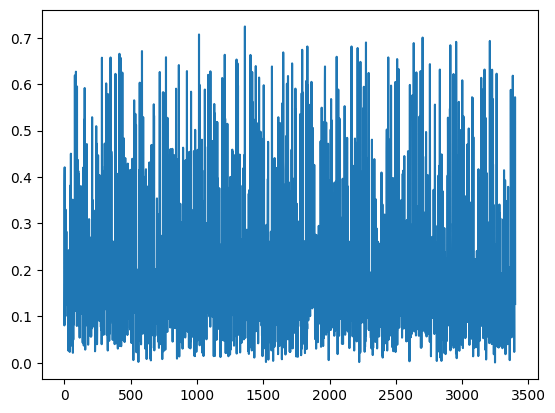

In [114]:
import matplotlib.pyplot as plt

plt.plot(np.abs(y_test - y_predict))